# Rolling Regression
Author: Thomas Wiecki

* [Pairs trading](https://www.quantopian.com/posts/pairs-trading-algorithm-1) is a famous technique in algorithmic trading that plays two stocks against each other.
* For this to work, stocks must be correlated (cointegrated).
* One common example is the price of gold (GLD) and the price of gold mining operations (GFI).

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt

Lets load the prices of GFI and GLD.

In [14]:
# from pandas_datareader import data
# prices = data.GoogleDailyReader(symbols=['GLD', 'GFI'], end='2014-8-1').read().loc['Open', :, :]

prices = pd.read_csv(pm.get_data('stock_prices.csv'))
prices['Date'] = pd.DatetimeIndex(prices['Date'])
prices = prices.set_index('Date')
prices.head()

,GFI,GLD
Date,,
2010-01-04,13.55,109.82
2010-01-05,13.51,109.88
2010-01-06,13.70,110.71
2010-01-07,13.63,111.07
2010-01-08,13.72,111.52


In [15]:
finite_idx = (np.isfinite(prices.GLD.values)) & (np.isfinite(prices.GFI.values))
prices = prices.iloc[finite_idx]

Plotting the prices over time suggests a strong correlation. However, the correlation seems to change over time.

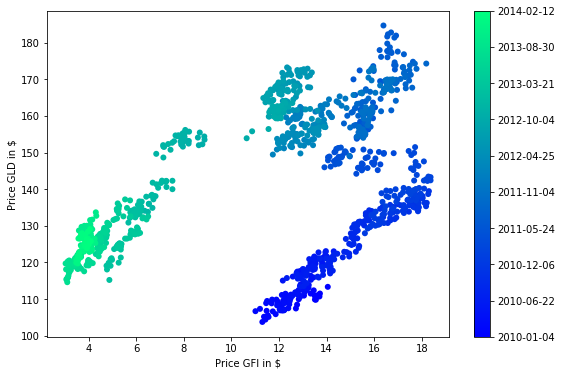

In [16]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, xlabel='Price GFI in \$', ylabel='Price GLD in \$')
colors = np.linspace(0.1, 1, len(prices))
mymap = plt.get_cmap("winter")
sc = ax.scatter(prices.GFI, prices.GLD, c=colors, cmap=mymap, lw=0)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in prices[::len(prices)//10].index]);

A naive approach would be to estimate a linear model and ignore the time domain.

In [5]:
with pm.Model() as model_reg:
    pm.glm.GLM.from_formula('GLD ~ GFI', prices)
    trace_reg = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 10,562:   7%|▋         | 14229/200000 [00:01<00:14, 13231.35it/s]   
Convergence archived at 15300
Interrupted at 15,300 [7%]: Average Loss = 3.0575e+06
100%|██████████| 2500/2500 [00:04<00:00, 501.23it/s]


The posterior predictive plot shows how bad the fit is.

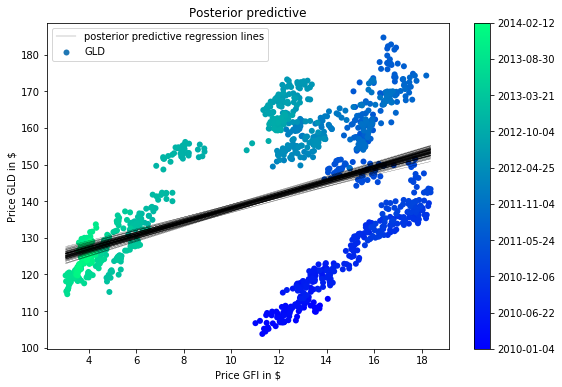

In [6]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, xlabel='Price GFI in \$', ylabel='Price GLD in \$', 
            title='Posterior predictive regression lines')
sc = ax.scatter(prices.GFI, prices.GLD, c=colors, cmap=mymap, lw=0)
pm.plot_posterior_predictive_glm(trace_reg[100:], samples=100, 
                              label='posterior predictive regression lines',
                              lm=lambda x, sample: sample['Intercept'] + sample['GFI'] * x,
                              eval=np.linspace(prices.GFI.min(), prices.GFI.max(), 100))
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in prices[::len(prices)//10].index]);
ax.legend(loc=0);

## Rolling regression

Next, we will build an improved model that will allow for changes in the regression coefficients over time. Specifically, we will assume that intercept and slope follow a random-walk through time. That idea is similar to the [stochastic volatility model](stochastic_volatility.ipynb).

$$ \alpha_t \sim \mathcal{N}(\alpha_{t-1}, \sigma_\alpha^2) $$
$$ \beta_t \sim \mathcal{N}(\beta_{t-1}, \sigma_\beta^2) $$

First, lets define the hyper-priors for $\sigma_\alpha^2$ and $\sigma_\beta^2$. This parameter can be interpreted as the volatility in the regression coefficients.

In [7]:
model_randomwalk = pm.Model()
with model_randomwalk:
    # std of random walk, best sampled in log space.
    sigma_alpha = pm.Exponential('sigma_alpha', 1./.02, testval = .1)
    sigma_beta = pm.Exponential('sigma_beta', 1./.02, testval = .1)

Next, we define the regression parameters that are not a single random variable but rather a random vector with the above stated dependence structure. So as not to fit a coefficient to a single data point, we will chunk the data into bins of 50 and apply the same coefficients to all data points in a single bin.

In [8]:
import theano.tensor as tt
# To make the model simpler, we will apply the same coefficient for 50 data points at a time
subsample_n = 50

lendata = len(prices)
ncoef = lendata // subsample_n
idx = range(ncoef * subsample_n)
with model_randomwalk:
    alpha = pm.GaussianRandomWalk('alpha', sigma_alpha**-2, 
                                  shape=ncoef)
    beta = pm.GaussianRandomWalk('beta', sigma_beta**-2, 
                                 shape=ncoef)
    
    # Make coefficients have the same length as prices
    alpha_r = tt.repeat(alpha, subsample_n)
    beta_r = tt.repeat(beta, subsample_n)    

Perform the regression given coefficients and data and link to the data via the likelihood.

In [9]:
with model_randomwalk:
    # Define regression
    regression = alpha_r + beta_r * prices.GFI.values[idx]
    
    # Assume prices are Normally distributed, the mean comes from the regression.
    sd = pm.Uniform('sd', 0, 20)
    likelihood = pm.Normal('y', 
                           mu=regression, 
                           sd=sd, 
                           observed=prices.GLD.values[idx])

Inference. Despite this being quite a complex model, NUTS handles it wells.

In [10]:
with model_randomwalk:
    trace_rw = pm.sample(2000, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 6,731.4:  17%|█▋        | 33432/200000 [00:04<00:22, 7349.00it/s]  
Convergence archived at 33700
Interrupted at 33,700 [16%]: Average Loss = 25,406
 90%|████████▉ | 2248/2500 [01:26<00:11, 21.24it/s]/usr/local/lib/python3.5/dist-packages/pymc3/step_methods/hmc/nuts.py:448: UserWarning: Chain 1 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
/usr/local/lib/python3.5/dist-packages/pymc3/step_methods/hmc/nuts.py:456: UserWarning: Chain 1 contains 7 diverging samples after tuning. If increasing `target_accept` doesn't help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 2494/2500 [01:34<00:00, 38.26it/s]/usr/local/lib/python3.5/dist-packages/pymc3/step_methods/hmc/nuts.py:448: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  're

## Analysis of results

$\alpha$, the intercept, does not seem to change over time.

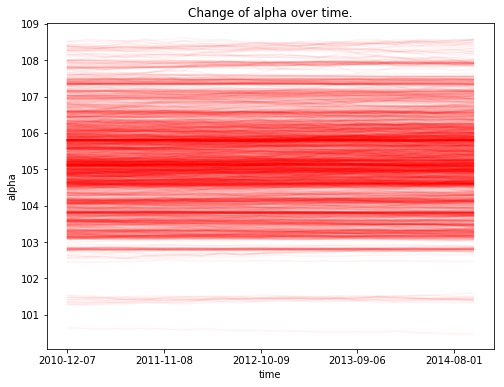

In [11]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111, xlabel='time', ylabel='alpha', title='Change of alpha over time.')
ax.plot(trace_rw[-1000:]['alpha'].T, 'r', alpha=.05);
ax.set_xticklabels([str(p.date()) for p in prices[::len(prices)//5].index]);

However, the slope does.

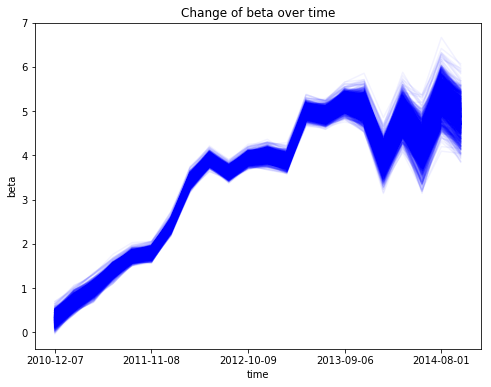

In [12]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, xlabel='time', ylabel='beta', title='Change of beta over time')
ax.plot(trace_rw[-1000:]['beta'].T, 'b', alpha=.05);
ax.set_xticklabels([str(p.date()) for p in prices[::len(prices)//5].index]);

The posterior predictive plot shows that we capture the change in regression over time much better. Note that we should have used returns instead of prices. The model would still work the same, but the visualisations would not be quite as clear.

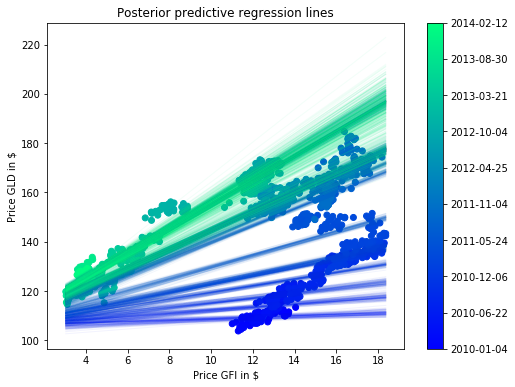

In [13]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, xlabel='Price GFI in \$', ylabel='Price GLD in \$', 
            title='Posterior predictive regression lines')

colors = np.linspace(0.1, 1, len(prices))
colors_sc = np.linspace(0.1, 1, len(trace_rw[-500::10]['alpha'].T))
mymap = plt.get_cmap('winter')
mymap_sc = plt.get_cmap('winter')

xi = np.linspace(prices.GFI.min(), prices.GFI.max(), 50)
for i, (alpha, beta) in enumerate(zip(trace_rw[-500::10]['alpha'].T, trace_rw[-500::10]['beta'].T)):
    for a, b in zip(alpha, beta):
        ax.plot(xi, a + b*xi, alpha=.05, lw=1, c=mymap_sc(colors_sc[i]))
        
sc = ax.scatter(prices.GFI, prices.GLD, label='data', cmap=mymap, c=colors)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in prices[::len(prices)//10].index]);